**Install dependencies**

In [ ]:
# %%capture
# try:
#     import miniai
# except ImportError:
#     !git clone https://github.com/fastai/course22p2.git
#     !pip install -e ./course22p2

In [ ]:
# %%capture
# !pip install -U torch torchvision torchaudio
# !pip install -U pillow pandas gradio kaggle timm bitsandbytes
# !pip install -U cjm_pil_utils cjm_pytorch_utils cjm_kaggle_utils cjm_pandas_utils

In [ ]:
# !pip install -U --pre timm

**Import dependencies**

In [ ]:
from pathlib import Path
import hashlib
import json
import random
import multiprocessing
import math
import os
from functools import partial
from copy import copy

import gradio as gr
from PIL import Image
import numpy as np
import timm

import pandas as pd
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PyTorch dependencies
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torcheval.tools import get_module_summary

# Import fastai dependencies
import fastcore.all as fc
from miniai.datasets import DataLoaders
from miniai.conv import def_device
from miniai.learner import *
from miniai.activations import Hook
from miniai.accel import MixedPrecision, AccelerateCB
from miniai.sgd import BatchSchedCB
from miniai.init import set_seed

# Import utility functions
from cjm_kaggle_utils.core import save_kaggle_creds, dl_kaggle
from cjm_pil_utils.core import resize_img, get_img_files, stack_imgs
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, iterate_modules, tensor_stats_df
from cjm_pandas_utils.core import markdown_to_pandas

In [ ]:
from diffusers import AutoencoderKL

In [ ]:
import wandb
wandb.login()

wandb: Currently logged in as: millscj. Use `wandb login --relogin` to force relogin


True

In [ ]:
set_seed(42)

**Enter Kaggle username and API token**

In [ ]:
username = ""
key = ""

**Save Kaggle credentials to file**

In [ ]:
save_kaggle_creds(username, key, overwrite=False)

Empty username.


**Define directory paths**

In [ ]:
# Define path to store datasets
dataset_dir = Path("/mnt/980_1TB_2/Datasets/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)
print(f"Dataset Directory: {dataset_dir}")

# Define path to store archive files
archive_dir = dataset_dir/'../Archive'
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)
print(f"Archive Directory: {archive_dir}")

Dataset Directory: /mnt/980_1TB_2/Datasets
Archive Directory: /mnt/980_1TB_2/Datasets/../Archive


**Define Kaggle dataset**

In [ ]:
# Set the name of the dataset
dataset_name = 'pexels-110k-512p-min-jpg'
# dataset_name = 'pexels-110k-768p-min-jpg'

# Construct the Kaggle dataset name by combining the username and dataset name
kaggle_dataset = f'innominate817/{dataset_name}'

# Create the path to the zip file that contains the dataset
archive_path = Path(f'{archive_dir}/{dataset_name}.zip')
print(f"Archive Path: {archive_path}")

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name}')
print(f"Dataset Path: {dataset_path}")

Archive Path: /mnt/980_1TB_2/Datasets/../Archive/pexels-110k-512p-min-jpg.zip
Dataset Path: /mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg


**Download Kaggle dataset**

In [ ]:
dl_kaggle(kaggle_dataset, archive_dir, dataset_path)

Dataset already downloaded


**Define path to image folder**

In [ ]:
src_img_dir = Path(dataset_path/"images")
src_img_dir

Path('/mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg/images')

**Get source images**

In [ ]:
# Get a list of the paths to the images in the images directory
src_img_paths = get_img_files(src_img_dir)

# Print the number of images in the images directory
print(len(src_img_paths))

109971


**Map image IDs to file paths**

In [ ]:
# Create a dictionary mapping image IDs to image paths
src_img_path_dict = {int(path.stem.split('-')[-1]) : path for path in src_img_paths}

# Display the first few entries in the dictionary using a Pandas Dataframe
pd.DataFrame.from_dict(src_img_path_dict, orient='index').head()

,0
1061142,/mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg/images/1-art-background-1061142.jpg
2586334,/mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg/images/1-person-beauty-face-blurred-background-2586334.jpg
1460032,/mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg/images/1-wtc-artist-concert-1460032.jpg
1061133,/mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg/images/10-art-artistic-1061133.jpg
1339845,/mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg/images/10-art-color-1339845.jpg


In [ ]:
grayscale_img_ids_file_path = Path(dataset_path/"grayscale_img_ids.txt")
grayscale_img_ids_file_path

Path('/mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg/grayscale_img_ids.txt')

In [ ]:
with open(grayscale_img_ids_file_path, "r") as read_file:
    greyscale_img_ids = read_file.readlines()
    
greyscale_img_ids = [int(img_id.removesuffix('\n')) for img_id in greyscale_img_ids]
print(f"Number greyscale images: {len(greyscale_img_ids)}")
greyscale_img_ids[0]

Number greyscale images: 7284


104832

In [ ]:
greyscale_img_path_dict = {img_id:src_img_path_dict[img_id] for img_id in greyscale_img_ids}

**Store list of image IDs**

In [ ]:
img_ids = [img_id for img_id in src_img_path_dict.keys() if img_id not in greyscale_img_path_dict]
len(img_ids)

102687

In [ ]:
# img_ids = list(src_img_path_dict.keys())
# len(img_ids)

**Select a subset of image IDs for training**

In [ ]:
img_ids_subset = img_ids
# img_ids_subset = random.sample(img_ids, 50)
len(img_ids_subset)

102687

In [ ]:
def is_mostly_grayscale(img, threshold=0.9, std_threshold=3):
    
    img_array = np.array(img)

    # Compute the standard deviation of the RGB values across each pixel
    std_dev = np.std(img_array, axis=2)

    # Compute the number of grayscale pixels (i.e., pixels where the standard deviation is low)
    num_grayscale = np.sum(std_dev < std_threshold)

    # Compute the total number of pixels in the img_array
    total_pixels = img_array.shape[0] * img_array.shape[1]

    # Compute the percentage of grayscale pixels
    percent_grayscale = num_grayscale / total_pixels
#     print(percent_grayscale)

    # Check if the percentage of grayscale pixels is above the threshold
    return percent_grayscale# > threshold

In [ ]:
def get_grayscale_pct(img_tensor, std_threshold=3):
    
    # Compute the standard deviation of the RGB values across each pixel
    std_dev = torch.std(img_tensor*255, dim=0)

    # Compute the number of grayscale pixels (i.e., pixels where the standard deviation is low)
    num_grayscale = torch.sum(std_dev < torch.Tensor([std_threshold]))

    # Compute the total number of pixels in the img_tensor
    total_pixels = img_tensor.shape[-2] * img_tensor.shape[-1]
    
    # Compute the percentage of grayscale pixels
    percent_grayscale = num_grayscale / total_pixels
    
    # Check if the percentage of grayscale pixels is above the threshold
    return percent_grayscale

In [ ]:
def denorm_img_tensor(img_tensor, mean, std):
    mean_tensor = torch.Tensor(mean).view(1,1,-1).permute(2, 0, 1)
    std_tensor = torch.Tensor(std).view(1,1,-1).permute(2, 0, 1)
    return img_tensor*std_tensor+mean_tensor

In [ ]:
imagenet_stats = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

**Display sample image**

ID: 1858234
Grayscale: 39.220%
Grayscale: 31.008%


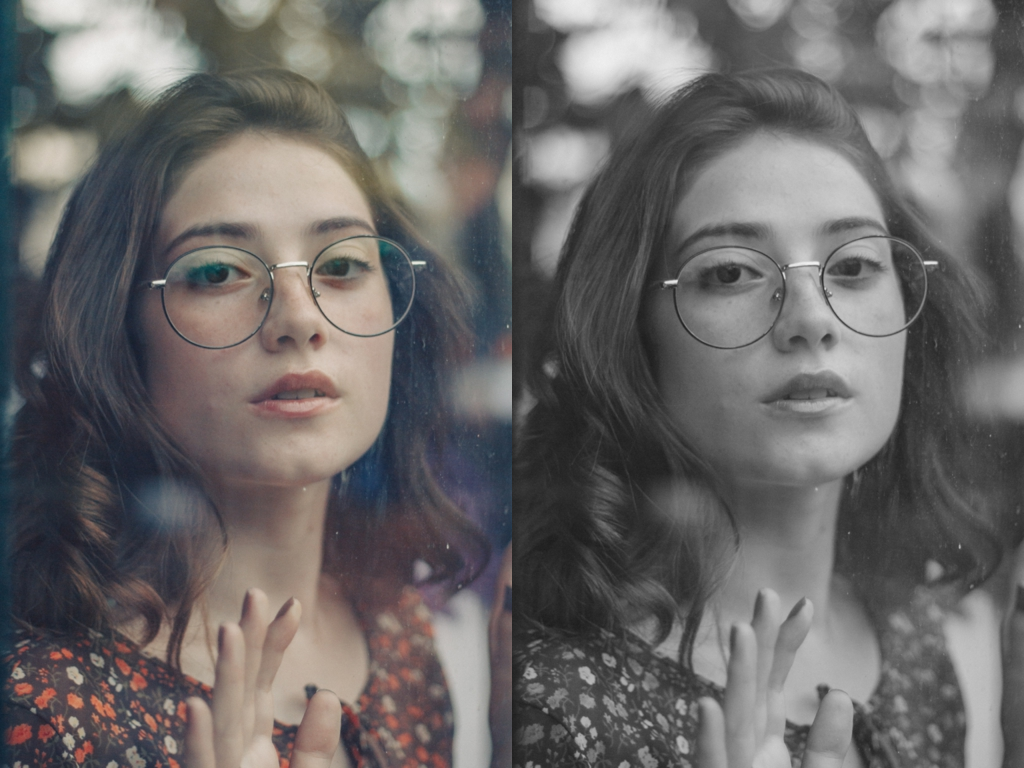

In [ ]:
# Choose a random image ID from the list of image IDs
img_id = random.choice(img_ids_subset)

img_id = 1858234

print(f"ID: {img_id}")

# Open the image located at the path in the img_path_dict with the key of the current img_id
img_path = src_img_path_dict[img_id]
sample_img = Image.open(img_path)
# sample_img = resize_img(sample_img, 296)

print(f"Grayscale: {is_mostly_grayscale(sample_img,  std_threshold=6)*100:.3f}%")
print(f"Grayscale: {get_grayscale_pct(transforms.ToTensor()(sample_img),  std_threshold=6)*100:.3f}%")

greyscale_img = sample_img.convert("L").convert("RGB")

# Display the image
stack_imgs([sample_img, greyscale_img])

**Select PyTorch compute device**

In [ ]:
device = def_device
device

'cuda'

**Define model data type**

In [ ]:
train_dtype = torch.float32

**Define style transfer model normalization stats**

In [ ]:
# Normalize to the range [-0.5, 0.5]
norm_stats = [0.5], [1.0]

**Convert sample image to tensor**

In [ ]:
# Convert image to a normalized and batched tensor 
img_tensor = pil_to_tensor(greyscale_img, *norm_stats).to(device=device, dtype=train_dtype)
tensor_stats_df(img_tensor)

,0
mean,-0.090697
std,0.183555
min,-0.390196
max,0.44902
shape,"(1, 3, 768, 512)"


**Define training dataset class**

In [ ]:
class ColorizeDataset():
    """
    Dataset for colorizing greyscale images.
    """
    def __init__(
        self,
        img_ids,
        src_img_path_dict,
        norm_stats,
        size=512,
        random_flip=False,
        center_crop=False,
    ):
        """
        Initialize the dataset.
        
        Parameters:
            img_ids (List): List of image IDs.
            src_img_path_dict (Dict): Dictionary of image IDs and corresponding image paths.
            norm_stats (Tuple): Mean and standard deviation for normalization.
            size (int, optional): Image size. Default: 512
            random_flip (bool, optional): Flag to random flip image. Default: False
            center_crop (bool, optional): Flag to center crop image. Default: False
        """
        self.img_ids = img_ids
        self.src_img_path_dict = src_img_path_dict
        
        self.size = size
        self.center_crop = center_crop
        
        # Compose a list of image transforms
        self.tfms_list = [
            transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
            transforms.ToTensor(),
            transforms.Normalize(*norm_stats)
        ]
        
        if random_flip:
            # Add random horizontal flip to the transforms list
            self.tfms_list.insert(1, transforms.RandomHorizontalFlip(p=0.5))
        
        # Compose the final image transforms
        self.image_transforms = transforms.Compose(self.tfms_list)
        
    def __len__(self):
        """
        Return the length of the dataset.
        """
        return len(self.img_ids)
    
    def __getitem__(self, index):
        """
        Get the item at the specified index.
        
        Parameters:
            index (int): Index of the item to retrieve.
        
        Returns:
            torch.Tensor: Transformed image tensor.
        """
        img_id = self.img_ids[index % len(self.img_ids)]
        
        example = {}
        
        src_img_path = self.src_img_path_dict[img_id]
        src_img = Image.open(src_img_path)
        
        greyscale_img = src_img.convert("L").convert("RGB")
        
        return self.image_transforms(greyscale_img), self.image_transforms(src_img)

**Define training batch size**

In [ ]:
bs = 8

**Initialize datasets**

In [ ]:
train_sz = 296
# train_sz = 384
# train_sz = 512
# train_sz = 768

train_dataset = ColorizeDataset(
    img_ids=img_ids_subset,
    src_img_path_dict=src_img_path_dict,
    norm_stats=norm_stats,
    size=train_sz,
    random_flip=False,
    center_crop=True,
)

valid_dataset = copy(train_dataset)
valid_dataset.img_ids = img_ids_subset[-bs:]

len(train_dataset.img_ids), len(valid_dataset.img_ids)

(102687, 8)

**Inspect dataset sample**

In [ ]:
tensor_stats_df(train_dataset[0][0])

,0
mean,0.100445
std,0.055759
min,-0.452941
max,0.5
shape,"(3, 296, 296)"


In [ ]:
tensor_stats_df(train_dataset[0][1])

,0
mean,0.072587
std,0.311934
min,-0.488235
max,0.5
shape,"(3, 296, 296)"


**Initialize dataloaders**

In [ ]:
# Initializing the dataloader for train dataset
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=bs, 
                                               shuffle=True, 
                                               num_workers=multiprocessing.cpu_count(), 
                                               pin_memory=True)

# Initializing the dataloader for the validation dataset
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=bs)

# Creating a DataLoaders object from the train and validation dataloaders
dls = DataLoaders(train_dataloader, valid_dataloader)

# Print the number of batches in the training and validation dataloaders
len(dls.train), len(dls.valid)

(12836, 1)

**Define style transfer model**

In [ ]:
class ConvLayer(nn.Module):
    """
    Applies reflection padding followed by a 2D convolution operation.
    
    Parameters:
    in_channels (int): The number of input channels for the 2D convolution operation.
    out_channels (int): The number of output channels for the 2D convolution operation.
    kernel_size (int): The size of the convolution kernel.
    stride (int): The stride of the convolution operation.
    """
    def __init__(self, in_channels:int, out_channels:int, kernel_size:int, stride:int):
        super(ConvLayer, self).__init__()
        
        self.conv = nn.Sequential(nn.ReflectionPad2d(kernel_size // 2), 
                                  nn.Conv2d(in_channels, out_channels, kernel_size, stride))
    def forward(self, x):
        return self.conv(x)
    
class ResBlock(nn.Module):
    """
    A residual block that consists of two convolutional layers followed by instance normalization,
    and an activation function, with the output of the block being added to the input.
    
    Parameters:
    channels (int): The number of channels in the input tensor.
    act (nn.Module, optional): The activation function. Defaults to nn.ReLU.
    """
    def __init__(self, channels:int, act:nn.Module=nn.ReLU):
        super(ResBlock, self).__init__()
        self.convs = nn.Sequential(
            ConvLayer(channels, channels, kernel_size=3, stride=1),
            nn.InstanceNorm2d(channels, affine=True),
            act(),
            ConvLayer(channels, channels, kernel_size=3, stride=1),
            nn.InstanceNorm2d(channels, affine=True),
        )

    def forward(self, x):
        return self.convs(x) + x

class DownsampleShuffle(nn.Module):
    """
    Performs downsampling using a reverse PixelShuffle operation.
    
    Parameters:
    in_channels (int): The number of channels in the input tensor.
    out_channels (int): The number of channels in the output tensor.
    scale (int, optional): The scale factor used for shuffling. Defaults to 2.
    act (nn.Module, optional): The activation function. Defaults to nn.ReLU.
    """
    def __init__(self, in_channels:int, out_channels:int, scale:int=2, act:nn.Module=nn.ReLU):        
        super(DownsampleShuffle, self).__init__()
        
        self.downsample = nn.Sequential(nn.Conv2d(in_channels, out_channels//(scale**2), kernel_size=1, stride=1), 
                                        act(),
                                        nn.PixelUnshuffle(scale))
    def forward(self, x):
        return self.downsample(x)

class UpsampleShuffle(nn.Module):
    """
    Performs upsampling layer using a PixelShuffle operation.
    
    Parameters:
    in_channels (int): The number of channels in the input tensor.
    out_channels (int): The number of channels in the output tensor.
    scale (int, optional): The scale factor used for shuffling. Defaults to 2.
    act (nn.Module, optional): The activation function. Defaults to nn.ReLU.
    """
    def __init__(self, in_channels:int, out_channels:int, scale:int=2, act:nn.Module=nn.ReLU):
        super(UpsampleShuffle, self).__init__()
        
        self.upsample = nn.Sequential(nn.Conv2d(in_channels, out_channels*(scale**2), kernel_size=1, stride=1), 
                                      act(), 
                                      nn.PixelShuffle(scale))
    def forward(self, x):
        return self.upsample(x)

In [ ]:
class FastNeuralStyleNet(nn.Module):
    def __init__(self, chnls=[32,64,128], res_blocks=5, act=nn.ReLU):
        """
        Parameters:
        chnls (list, optional): List of channels. Default is [32, 64, 128].
        res_blocks (int, optional): Number of residual blocks. Default is 5.
        act (nn.Module, optional): Activation function. Default is nn.ReLU.
        """
        super(FastNeuralStyleNet, self).__init__()
        
        # Input layers
        self.inp_layers = nn.Sequential(ConvLayer(3, chnls[0], kernel_size=3, stride=1), 
                                        nn.InstanceNorm2d(chnls[0], affine=True), 
                                        act())
        
        # Downsampling
        self.downsample = nn.Sequential(*[nn.Sequential(DownsampleShuffle(chnls[i], chnls[i+1], scale=2), 
                                                        nn.InstanceNorm2d(chnls[i+1], affine=True),
                                                        act()) for i in range(len(chnls)-1)])
        # Residual Blocks
        self.res_blocks = nn.Sequential(*[ResBlock(chnls[-1]) for _ in range(res_blocks)])
        
        self.cross_convs = nn.ModuleList([ResBlock(n) for n in chnls[::-1]])
        
        # Upsampling
        self.upsample = nn.Sequential(*[nn.Sequential(UpsampleShuffle(chnls[i]*2, chnls[i-1], scale=2), 
                                                      nn.InstanceNorm2d(chnls[i-1], affine=True), 
                                                      act()) for i in range(len(chnls)-1, 0, -1)])
        # Output layers
        self.out_layers = nn.Sequential(ConvLayer(chnls[0], 3, kernel_size=3, stride=1), 
                                        nn.Sigmoid())
        
    def forward(self, X):
        
        # Downsampling
        down_out = [self.inp_layers(X)]
        for i, downsample in enumerate(self.downsample):
            down_out.append(downsample(down_out[i]))
        down_out.reverse() 
        
        # Residual Blocks
        up_out = [self.res_blocks(down_out[0])]
        
        # Upsampling
        for i, upsample in enumerate(self.upsample):
            up_out.append(upsample(torch.cat([self.cross_convs[i](down_out[i]), up_out[i]], dim=1)))
            
        return self.out_layers(up_out[-1])

**Instantiate style transfer model**

In [ ]:
chnls=[16,32,64]
# chnls=[32,64,128]
style_transfer_model = FastNeuralStyleNet(chnls=chnls, res_blocks=40).to(device)

**Initialize model weights**

In [ ]:
layer_type = nn.modules.conv.Conv2d
# Find all Conv2d layers in the model
conv_list = [module for module in iterate_modules(style_transfer_model) if type(module) == layer_type]

res_blocks = []
for conv in conv_list:
    # Initialize the weights of all Conv2d layers
    nn.init.kaiming_normal_(conv.weight)
    # Find all Conv2d layers in the res_blocks
    if conv.in_channels == chnls[-1]:
        res_blocks.append(conv)
        
# Zero out the weights of every second Conv2d layer in res_blocks
for i, conv in enumerate(res_blocks[:-1]):
    if i%2 != 0:
        conv.weight.data.zero_()

# Zero out the weights of the last Conv2d layer
conv_list[-1].weight.data.zero_();

**Get model summary**

In [ ]:
# Define the input to the model
test_inp = torch.randn(1, 3, *[train_dataset.size]*2).to(device)

# Get a summary of the model as a Pandas DataFrame
summary_df = markdown_to_pandas(f"{get_module_summary(style_transfer_model, [test_inp])}")

# Filter the summary to only contain Conv2d layers and the model
summary_df = summary_df[(summary_df.index == 0) | (summary_df['Type'] == 'Conv2d')]

# Remove the column "Contains Uninitialized Parameters?"
summary_df.drop('Contains Uninitialized Parameters?', axis=1)

,Type,# Parameters,# Trainable Parameters,Size (bytes),Forward FLOPs,Backward FLOPs,In size,Out size
0,FastNeuralStyleNet,3.1 M,3.1 M,12.3 M,17.2 G,34.4 G,"[1, 3, 296, 296]","[1, 3, 296, 296]"
5,Conv2d,448,448,1.8 K,37.9 M,37.9 M,"[1, 3, 298, 298]","[1, 16, 296, 296]"
12,Conv2d,136,136,544,11.2 M,22.4 M,"[1, 16, 296, 296]","[1, 8, 296, 296]"
20,Conv2d,528,528,2.1 K,11.2 M,22.4 M,"[1, 32, 148, 148]","[1, 16, 148, 148]"
31,Conv2d,36.9 K,36.9 K,147 K,201 M,403 M,"[1, 64, 76, 76]","[1, 64, 74, 74]"
37,Conv2d,36.9 K,36.9 K,147 K,201 M,403 M,"[1, 64, 76, 76]","[1, 64, 74, 74]"
44,Conv2d,36.9 K,36.9 K,147 K,201 M,403 M,"[1, 64, 76, 76]","[1, 64, 74, 74]"
50,Conv2d,36.9 K,36.9 K,147 K,201 M,403 M,"[1, 64, 76, 76]","[1, 64, 74, 74]"
57,Conv2d,36.9 K,36.9 K,147 K,201 M,403 M,"[1, 64, 76, 76]","[1, 64, 74, 74]"
63,Conv2d,36.9 K,36.9 K,147 K,201 M,403 M,"[1, 64, 76, 76]","[1, 64, 74, 74]"


**Load VAE model**

In [ ]:
model_name = "stabilityai/stable-diffusion-2-1"
vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae").to(device=device, dtype=train_dtype)

# vae.device = device
# Disable gradient calculation for the parameters
for param in vae.parameters():
    param.requires_grad = False

In [ ]:
# vae.encoder

**Select layers for perceptual loss**

In [ ]:
# Define the layer type to search for
layer_type = nn.modules.activation.SiLU

# Get a list of modules in the perception model
modules_list = list(iterate_modules(vae.encoder))

# Initialize an empty list to store the indices of modules of the desired type
vae_feat_layers = []

# Loop through the modules in the list
for i, module in enumerate(modules_list):
    if type(module) == layer_type:
        vae_feat_layers.append(i)
vae_feat_layers

[10, 17, 29, 37, 49, 57, 69, 76, 92, 99, 101]

**Select perception model**

In [ ]:
perception_model = vae
feat_layers = vae_feat_layers

In [ ]:
def tensor_to_latent(img_tensor:'torch.Tensor', # The tensor to be converted to latents.
                     vae:'AutoencoderKL' # The VAE model used to convert the image to latents.
                 ):
    """
    This function converts an image tensor to latents using a VAE model.
    
    Returns:
    latents (torch.Tensor): The latents generated from the image.
    """
    
    # Normalize the tensor
    img_tensor = (img_tensor - img_tensor.min()) / (img_tensor.max() - img_tensor.min())*2 - 1
    
    # Move the tensor to the correct device and type
    img_tensor = img_tensor.to(vae.device).type(vae.dtype)
    
    # Encode the image tensor to latents using the VAE model
#     with torch.no_grad():
    latent = vae.encode(img_tensor)
    
    # Return the latents
    return 0.18215 * latent.latent_dist.sample()

In [ ]:
# %%timeit
# tensor_to_latent(train_dataset[0][0][None], vae)

**Define hook function to store module outputs**

In [ ]:
def hook_fn(hook, module, inp, out):
    # Store the output of the module
    hook.outputs = out

**Define callable loss class**

In [ ]:
class PerceptualLoss():
    """
    Use a pre-trained perception model to extract features from the input tensors,
    and compares these features to calculate the content loss and style loss.
    """
    def __init__(self, 
                 perception_model:nn.Module, 
                 norm_stats:tuple, 
                 hook_fn, 
                 feat_layers:list,
                 content_wt:float=1e5):
        """
        Parameters:
        perception_model: A pre-trained deep learning model to be used for extracting features.
        norm_stats: The normalization statistics for the input tensor.
        hook_fn: A function to store the output of the intermediate layers.
        feat_layers: List of layer indices to be used for feature extraction.
        content_wt: The weight for the content loss.
        """
        self.perception_model = perception_model
        self.norm_stats = norm_stats
        self.hook_fn = hook_fn
        self.feat_layers = feat_layers
        self.content_wt = content_wt
        
#         self.hooks = []
#         self.hook_perception_model()
        
    def hook_perception_model(self):
        """
        Attach hooks to the specified layers in the perception model.
        """
        modules_list = list(iterate_modules(self.perception_model))
        self.hooks = [Hook(modules_list[layer], self.hook_fn) for layer in self.feat_layers]
                
    def get_features(self, inp_tensor:torch.Tensor):
        """
        Extract features from the input tensor using the perception model.
        """
        if self.perception_model.device == 'cuda':
            with torch.cuda.amp.autocast():
                self.perception_model(inp_tensor)
        else:
            self.perception_model(inp_tensor)
        features = [hook.outputs.float() for hook in self.hooks]
        return features
    
#     def __call__(self, x:torch.Tensor, y:torch.Tensor):
#         """
#         Calculate the content loss
#         """
#         features_x = self.get_features(transforms.Normalize(*self.norm_stats)(x+0.5))
#         features_y = self.get_features(transforms.Normalize(*self.norm_stats)(y))
        
#         content_loss = 0.
#         for i, (ft_y, ft_x) in enumerate(zip(features_y, features_x)):
#             content_loss += nn.functional.mse_loss(ft_y, ft_x)
        
#         content_loss *= self.content_wt
#         return content_loss
    
    def __call__(self, x:torch.Tensor, y:torch.Tensor):
        """
        Calculate the content loss
        """
        
        features_x = tensor_to_latent(x+0.5, self.perception_model)
        features_y = tensor_to_latent(y, self.perception_model)
        
#         features_x = self.get_features(transforms.Normalize(*self.norm_stats)(x+0.5))
#         features_y = self.get_features(transforms.Normalize(*self.norm_stats)(y))
        
        content_loss = 0.
#         for i, (ft_y, ft_x) in enumerate(zip(features_y, features_x)):
#             content_loss += nn.functional.mse_loss(ft_y, ft_x)
        
        content_loss += nn.functional.mse_loss(features_y, features_x)
        content_loss *= self.content_wt
        return content_loss

**Define perception model normalization stats**

In [ ]:
imagenet_stats = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

**Instantiate loss function**

In [ ]:
# VGG Weights
content_weight = 1e10

perceptual_style_loss = PerceptualLoss(perception_model=perception_model, 
                                            norm_stats=imagenet_stats,  
                                            hook_fn=hook_fn, 
                                            feat_layers=feat_layers,
                                            content_wt=content_weight)

In [ ]:
class WandBCB(MetricsCB):
    order=100
    def __init__(self, config, *ms, project:str, name:str=None, **metrics):
        fc.store_attr()
        self.train = False
        super().__init__(*ms, **metrics)
        
    def before_fit(self, learn): 
        if self.name:
            wandb.init(project=self.project, name=self.name, config=self.config)
        else:
            wandb.init(project=self.project, config=self.config)
    def after_fit(self, learn): wandb.finish()

    def _log(self, d): 
        if self.train: 
            wandb.log({'train_'+m:float(d[m]) for m in self.all_metrics})
        else: 
            wandb.log({'val_'+m:float(d[m]) for m in self.all_metrics})
        
    def sample_figure(self, learn):
        with torch.no_grad():
            samples = sample(learn.model, (16, 3, 32, 32))
        s = (samples[-1] + 0.5).clamp(0,1)
        plt.clf()
        fig, axs = get_grid(16)
        for im,ax in zip(s[:16], axs.flat): show_image(im, ax=ax)
        return fig

    def after_batch(self, learn):
        super().after_batch(learn) 
        wandb.log({'loss':learn.loss})
        
    def after_epoch(self, learn):
        self.train = learn.training
        super().after_epoch(learn)

In [ ]:
class StyleOptCB(MixedPrecision):
    """
    A training callback that performs mixed precision training for the style transfer process.
    """

    def predict(self, learn):
        """
        Generate predictions for the current batch.
        """
        with torch.cuda.amp.autocast():
            learn.preds = learn.model(learn.batch[0])
        
    def get_loss(self, learn):
        """
        Exit the autocast context before computing the loss for the current batch.
        """
        self.autocast.__exit__(None, None, None)
        learn.loss = learn.loss_func(learn.batch[1], learn.preds)

In [ ]:
class StyleOptAccelerateCB(AccelerateCB):
    """
    A training callback that uses HuggingFace Accelerate for the style transfer process.
    """
    def predict(self, learn):
        """
        Generate predictions for the current batch.
        """
        learn.preds = learn.model(learn.batch[0])
        
    def get_loss(self, learn):
        """
        Compute the loss for the current batch.
        """
        learn.loss = learn.loss_func(learn.batch[1], learn.preds)

In [ ]:
class OutOfBoundsCB(Callback):
    """
    A callback that exits the training session if the loss is not NaN or infinite.
    """
    def __init__(self, msg="Loss out of bounds"):
        fc.store_attr()
        
    def after_loss(self, learn):
        """
        Check if the loss is NaN or infinite.
        """
        if learn.loss.detach().isnan() or learn.loss.detach().isinf(): 
            print(self.msg)
            raise CancelFitException()

In [ ]:
class ImageCheckpointCB(Callback):
    """
    A callback for saving images at intervals during training.
    
    Parameters:
    cp_int (int): Interval for saving checkpoint images.
    cp_path (str): Directory path to save checkpoint images.
    img_tensor (torch.Tensor): An image tensor to use as input to the model for checkpoint predictions.
    """
    def __init__(self, cp_int, cp_path, img_tensor):
        fc.store_attr()
        
    def after_loss(self, learn):
        if learn.iter != 0 and learn.iter%self.cp_int == 0:
            with torch.no_grad():
                pred = learn.model(img_tensor)
                
            # Convert the tensor to a PIL image
            test_img = tensor_to_pil(pred.squeeze())
            
            # Save the image to disk
            file_name = f"epoch-{learn.epoch}-batch-{learn.iter}.png"
            test_img.save(self.cp_path/file_name, fmt="PNG")

In [ ]:
class ModelCheckpointCB(Callback):
    """
    A callback to save model checkpoints at intervals during training.
    """
    def __init__(self, cp_int, cp_path):
        fc.store_attr()
        
    def after_loss(self, learn):
        if learn.iter != 0 and learn.iter%self.cp_int == 0:
            # Save the model's state dict to disk
            file_name = f"model-epoch-{learn.epoch}-batch-{learn.iter}.pth"
            torch.save(learn.model.state_dict(), Path(self.cp_path/file_name))

In [ ]:
# style_transfer_model.load_state_dict(torch.load(checkpoint_path/"model-epoch-1-batch-2500.pth"));

In [ ]:
cbs = [StyleOptAccelerateCB(),
       OutOfBoundsCB(),
       DeviceCB(), 
       ProgressCB(plot=True)]

**Select optimizer**

In [ ]:
opt_func = partial(torch.optim.AdamW, eps=1e-4)

**Set learning rate scheduler**

In [ ]:
# Max learning rate to use.
lr = 1e-3
# Total number of training epochs
epochs = 1

tmax = epochs * len(dls.train)
sched = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs.append(BatchSchedCB(sched))

In [ ]:
project_name = "fast_colorize_miniai-vae"
run_name = "40-resblocks"
project_config = {'lr':lr, 'epochs':epochs}

wandbcb =  WandBCB(config=project_config, 
                   project=project_name,
                   name=run_name
                  )
cbs.append(wandbcb)

In [ ]:
# Create a directory to store the checkpoints if it does not already exist
checkpoint_dir = Path(f"./{project_name}/")
checkpoint_dir.mkdir(parents=True, exist_ok=True)


# Create a name for the checkpoint based on the dataset and style image names and the training size
checkpoint_name = f"{dataset_path.stem.lower()}-{train_sz}p"
checkpoint_path = Path(checkpoint_dir/f"{checkpoint_name}")
checkpoint_path.mkdir(parents=True, exist_ok=True)

# Define the path to save the trained model
model_path = Path(checkpoint_path/"model.pth")

# Print the checkpoint path
checkpoint_path

Path('fast_colorize_miniai-vae/pexels-110k-512p-min-jpg-296p')

**Initialize checkpoint callbacks**

In [ ]:
checkpoint_interval = 500
img_checkpoint_cb = ImageCheckpointCB(checkpoint_interval, checkpoint_path, img_tensor)
model_checkpoint_cb = ModelCheckpointCB(checkpoint_interval, checkpoint_path)

cbs.extend([img_checkpoint_cb, model_checkpoint_cb])

In [ ]:
learn = Learner(style_transfer_model, (dls), perceptual_style_loss, lr=lr, cbs=cbs, opt_func=opt_func)

In [ ]:
learn.fit(epochs)


KeyboardInterrupt



**Set inference data type**

In [ ]:
infer_dtype = torch.float16

**Set style transfer model to evaluation mode**

In [ ]:
style_transfer_model.to(device=device, dtype=infer_dtype);
style_transfer_model.eval();

**Set input size**

In [ ]:
infer_sz = 512

**Test style transfer model on sample images**

ID: 2904775
New Dimensions: (736, 512)


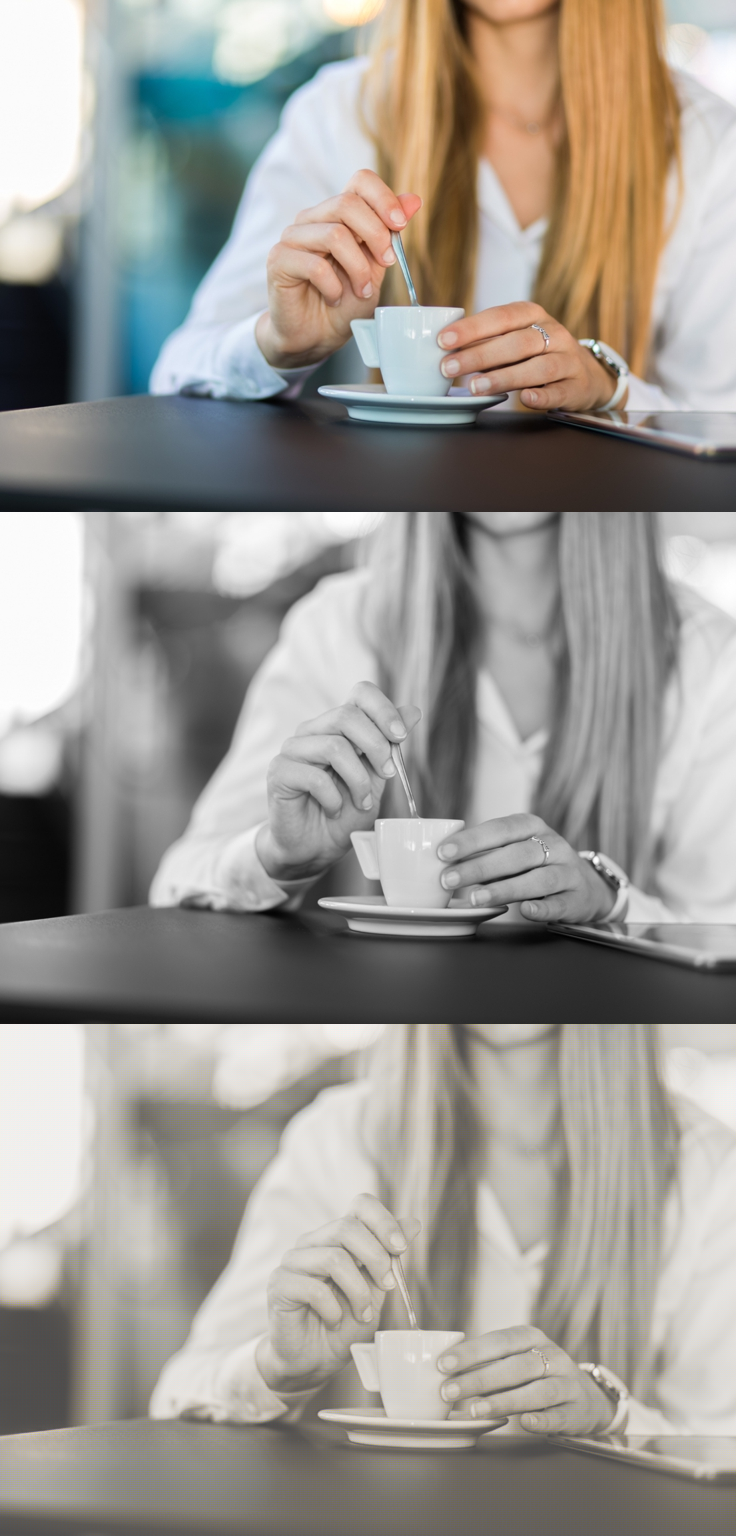

In [ ]:
# Select a random image ID from the subset of available IDs
img_id = random.choice(img_ids_subset)
# img_id = "1536428"

# Print the selected image ID
print(f"ID: {img_id}")

# Get the file path of the selected image using the dictionary
img_path = src_img_path_dict[img_id]

# Open the selected image and convert to greyscale
sample_img = Image.open(img_path)

# Resize the image to the desired size
sample_img = resize_img(sample_img, target_sz=infer_sz, divisor=8)

# Print the new dimensions of the image
print(f"New Dimensions: {sample_img.size}")

greyscale_img = sample_img.convert("L").convert("RGB")

# Convert the image to a tensor
img_tensor = pil_to_tensor(greyscale_img, *norm_stats).to(device=device, dtype=infer_dtype)

# Run the image through the style transfer model and store the result in `pred`
with torch.no_grad():
    pred = style_transfer_model(img_tensor)

# Convert the output tensor to an image
colorized_img = tensor_to_pil(pred.squeeze())

# Stack the greyscale image and the colorized image together
stack_imgs([sample_img, greyscale_img, colorized_img])

In [ ]:
stop

**Set values for exporting the model to ONNX**

In [ ]:
opset_version = 11
export_dtype = train_dtype
export_dtype_str = f"{export_dtype}".split('.')[-1]

**Define save path for ONNX model**

In [ ]:
onnx_file_path = Path(checkpoint_path/f"model-opset-{opset_version}-{export_dtype_str}.onnx")
onnx_file_path

**Export model to ONNX**

In [ ]:
torch.onnx.export(style_transfer_model.to(dtype=export_dtype),
                  img_tensor.to(dtype=export_dtype),
                  onnx_file_path,
                  export_params=True,
                  opset_version=opset_version,
                  do_constant_folding=False
                 )